# Case study of automated inference of qualitative models of ecological system: the Protists system

We apply the software [*BoNesis*](https://github.com/bnediction/bonesis) for the inference of qualitative models of ecological systems from *observations* and *expert knowledge* of the Protists system.

The resulting qualitative models are *Boolean networks*, which describe the change of activity state (on/off) of species using Boolean functions. These models can then predict successive state changes, possibly non-deterministic, and the stable regimes.

From a same set of observations of transitions, we show how to incorporate different levels of expert knowledge to infer Boolean networks explaining the observed transitions.

In [1]:
import bonesis

from protists import *

from tqdm.notebook import *

import multiprocessing
bonesis.settings["parallel"] = multiprocessing.cpu_count()

from IPython.display import display, Markdown

We consider 6 species:

In [2]:
species

['A', 'B', 'E', 'C', 'P', 'T']

## Observations

We have observations of *transitions* of the system, they are represented in black in the following figure:

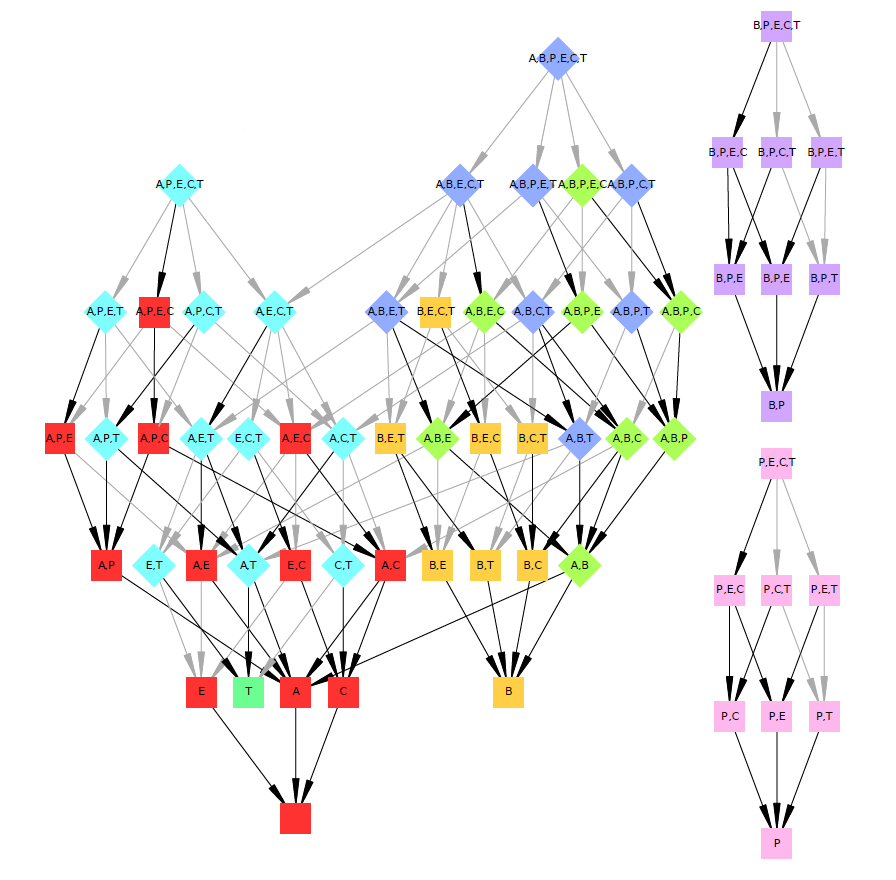

There are 71 observed transitions:

In [3]:
len(obs.edges()), len(obs.nodes())

(71, 63)

Moreover, all the transitions modify the state of only one species:

In [4]:
{len(set(x).symmetric_difference(set(y.replace('_', '')))) for x, y in obs.edges()}

{1}

We make the hypothesis that states with ingoing transitions but without outgoing observed transitions are *steady states* of the system.

In [5]:
steady

{'B', 'BP', 'P', 'T', '_'}

# Modeling dynamical properties and evaluating models

In the following, we aim at infering executable qualitative models of the system, by the means of Boolean networks (BNs).
A configuration of such a model assigns a Boolean state to each species. Then, the BN specifies how the state of each species can change according to the state of the others.

In our case study, we expect that a BN verifies *at least* the following dynamical properties:
- each observed transition is a transition possible in the BN by updating the state of only one species
- the observed steady states correspond to fixed points of the BN dynamics: there must not exist any transition from these configurations in the BN.

Many different BNs may fulfill these properties. We will consider two measures to distinguish among them:
- *sparsity*: we will focus on BNs requiring a minimum set of influences (interactions) between species. The minimality criteria is computed with respect to set inclusions: a set of influences is minimal if there is no BN -using a strict subset of them while verifying the required dynamical properties. Note that there may exist several minimal BNs.

- *deviation*: we are interested in having models reproducing the observations as closely as possible. While we impose that a BN have *at least* the observed transitions, we can compute how many additional *unobserved* transitions are predicted by the model from the observed states. The less deviation the better.

In [6]:
def model_deviation(f):
    return len(list(deviating_fasync_transitions(f, obs, cfg_of_present)))

# Integrating expert knowledge

Besides the observations of the system, a model can also integrate expert knowledge, i.e., respect *a prioris* on its structure and dynamics.

In this report, we show the impact of expert knowledge on the structure of the model, in particular on the underlying trophic network. We will consider 3 inference scenarios:
1. without prior knowledge on trophic interactions, but imposing the absence of cyclic trophic relations
2. with prior knowledge on the trophic network from https://doi.org/10.1046/j.1365-2656.1998.00212.x
3. with prior knowledge on the trophic network from https://doi.org/10.22541/au.164301558.85072720/v1

## Inference without prior knowledge on the trophic network.

Knowledge on the trophic network indicates possible and impossible trophic relation between species. In practice, this knowledge may be difficult to constitute, and is often incomplete.
In this section, we perform the model inference without specific constraints on the trophic relations.
Nevertheless, to obtain realistic models, we impose that the trophic network is acyclic.

In [7]:
dom = bonesis.InfluenceGraph(dom_any)
declare_acyclic_trophy_network(dom)
bo = bonesis.BoNesis(dom)
model_observations(bo)

### Minimal model

We first identify the model using as less as relations as possible while being able to reproduce the observed transitions.

In [8]:
view = bonesis.InfluenceGraphView(bo, solutions="subset-minimal", limit=5,
            extra="boolean-network", progress=tqdm)
MIN_res = res = list(tqdm(view))
res.sort(key=keysort_result)
len(res)

0it [00:00, ?it/s]

Grounding...done in 1.6s


1

# computing graph layout...


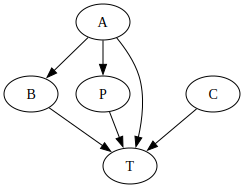

In [9]:
ig0, f0 = res[0]
trophic_of_influence_graph(ig0)

In [10]:
model_deviation(f0)

81

In [11]:
MIN_res[0][1]

A <- 0
B <- !A&B
C <- 0
E <- 0
P <- !A&P
T <- !A&!P&!B&T&!C

In [12]:
MIN_res[0][1].save("MIN.bn")

### Minimizing deviation

*BoNesis* allows specifying objectives and, in that case, returns models that minimize these objectives. In our case, we are interested in the models that have the least unobserved transitions as possible.

In [13]:
minimize_deviation(bo)

In [14]:
%%time
view = bonesis.InfluenceGraphView(bo, solutions="subset-minimal", limit=5,
            mode="optN", clingo_opt_strategy="bb", extra="boolean-network", progress=tqdm)
ZKM_res = res = list(tqdm(view))
res.sort(key=keysort_result)
len(res)

0it [00:00, ?it/s]

Grounding...done in 2.1s


Model optimization: 0it [00:00, ?it/s]

CPU times: user 10min 56s, sys: 4.46 s, total: 11min 1s
Wall time: 3min 2s


3

In [15]:
model_deviation(res[0][1])

18

It results in 3 different models, all minimizing the deviation. It is therefore impossible to have a better model, i.e., which introduce less than 18 unobserved transitions, without introducing new species, or relaxing the global acyclic constraint on trophic relations.

**Solution 1**

A <- (A&E)|(A&P)|(A&B&T)|(A&T&C)
B <- (!A&B)|(B&C)|(B&T)
C <- !A&T&C
E <- (T&E&C)|(P&T&E)
P <- (!A&P)|(P&B&C)|(P&B&T)|(P&T&C)
T <- !A&!P&!B&T&!C

# computing graph layout...


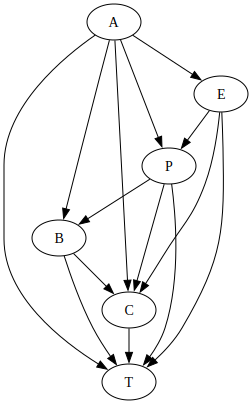

**Solution 2**

A <- (A&E)|(A&P)|(A&B&T)|(A&T&C)
B <- (!A&B)|(B&C)|(B&E)|(B&T)
C <- !A&T&C
E <- T&E&C
P <- (!A&P)|(P&B&C)|(P&B&T)|(P&E&C)|(P&T&C)|(P&T&E)
T <- !A&!P&!B&T&!C

# computing graph layout...


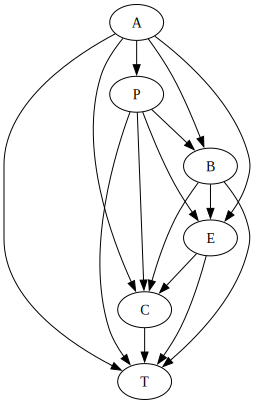

**Solution 3**

A <- (A&E)|(A&P)|(A&B&T)|(A&T&C)
B <- (!A&B)|(B&C)|(B&E)|(P&B)|(B&T)
C <- !A&T&C
E <- T&E&C
P <- (!A&P)|(P&!B&E)|(P&E&C)|(P&T&C)|(P&T&E)
T <- !A&!P&!B&T&!C

# computing graph layout...


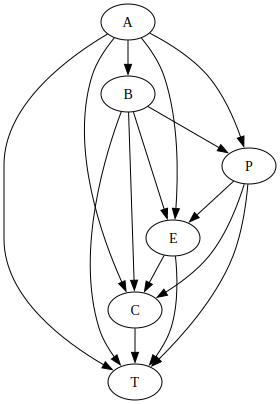

In [16]:
for i, (ig, f) in enumerate(res):
    display(Markdown(f"**Solution {i+1}**"))
    print(f)
    display(trophic_of_influence_graph(ig))

In the following, we compute the transitions predicted by the latter model:

In [17]:
ZKM_res[0][1]

A <- (A&E)|(A&P)|(A&B&T)|(A&T&C)
B <- (!A&B)|(B&C)|(B&T)
C <- !A&T&C
E <- (T&E&C)|(P&T&E)
P <- (!A&P)|(P&B&C)|(P&B&T)|(P&T&C)
T <- !A&!P&!B&T&!C

In [18]:
ZKM_res[1][1]

A <- (A&E)|(A&P)|(A&B&T)|(A&T&C)
B <- (!A&B)|(B&C)|(B&E)|(B&T)
C <- !A&T&C
E <- T&E&C
P <- (!A&P)|(P&B&C)|(P&B&T)|(P&E&C)|(P&T&C)|(P&T&E)
T <- !A&!P&!B&T&!C

In [19]:
ZKM_res[2][1]

A <- (A&E)|(A&P)|(A&B&T)|(A&T&C)
B <- (!A&B)|(B&C)|(B&E)|(P&B)|(B&T)
C <- !A&T&C
E <- T&E&C
P <- (!A&P)|(P&!B&E)|(P&E&C)|(P&T&C)|(P&T&E)
T <- !A&!P&!B&T&!C

## Inference from WLW Prior

We now restrict the possible influence a BN by assuming the WLW prior trophic network:
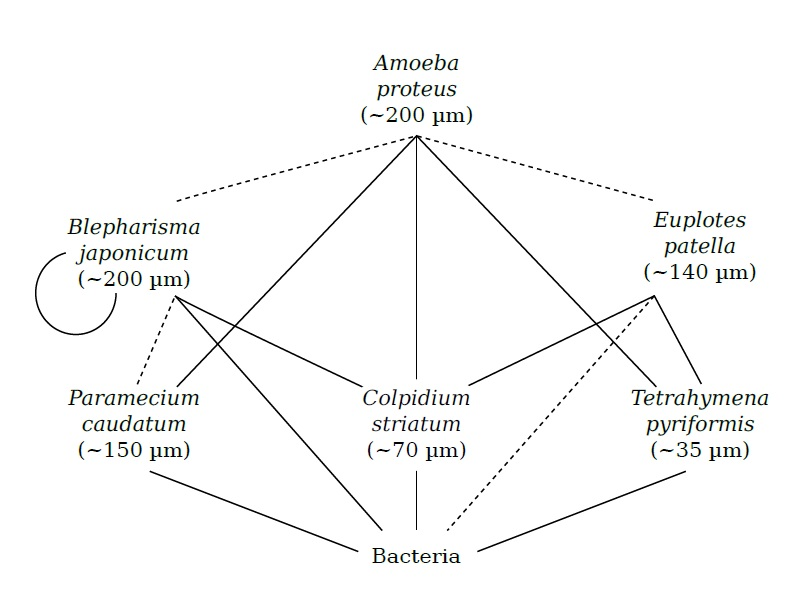

However, there is no possible BN reproducing the observations using only these interactions:

In [20]:
bo = bonesis.BoNesis(dom_english)
model_observations(bo, max_changes=1)
bo.is_satisfiable()

False

Therefore, the trophic network must be completed.

## de Goër de Hervé  Prior

de Goër de Herve *et al* proposed in 2022 a qualitative model for the observed transitions described in the following figure:
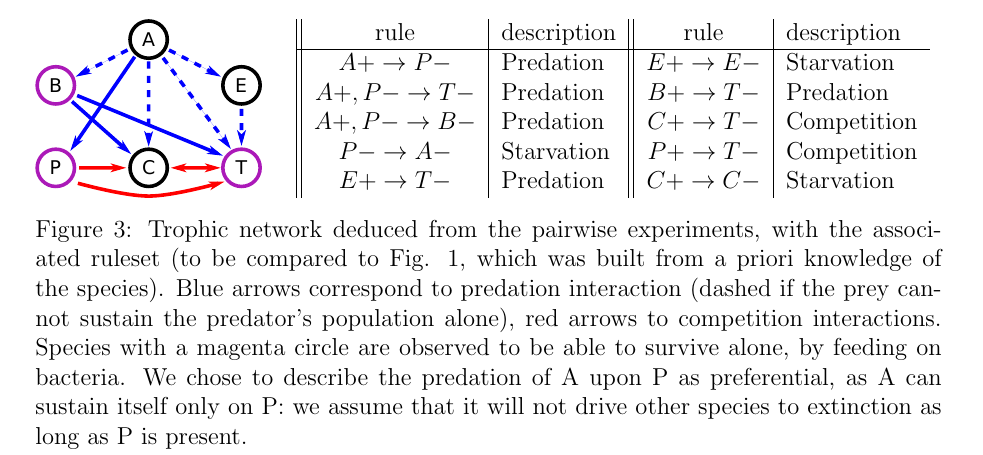

It should be noted that the trophic network of the figure of the original article is incomplete: their model actually relies on the predation of P by B (rule "A+,P- -> B-", i.e., in the absence of P, B goes extinct).

The model actually relies the following trophic relations:

# computing graph layout...


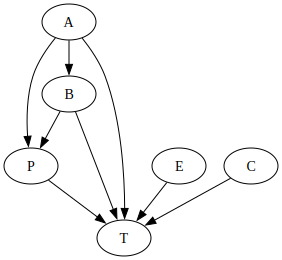

In [21]:
trophic_of_influence_graph(f_goer.influence_graph())

The transitions of this model are represented in gray in Figure 1.  Its deviation score is *60*:

In [22]:
model_deviation(f_goer)

60

In the following, we will perform model inference from the same trophic network. This may result in obtaining different models but potentially with less deviation:

In [23]:
bo = bonesis.BoNesis(dom_goer_fixed)
model_observations(bo)
minimize_deviation(bo)
view = bonesis.InfluenceGraphView(bo, solutions="subset-minimal", limit=5,
            mode="optN", extra="boolean-network")
EEM_res = res = list(tqdm(view))
len(res)

0it [00:00, ?it/s]

Grounding...done in 0.7s


1

Only one optimal model is found, with a much lower deviation:

In [24]:
ig, f = res[0]
model_deviation(f)

34

In [25]:
f

A <- (A&P)|(A&B&E)|(A&B&T)|(A&E&C)|(A&T&C)|(A&T&E)
B <- (!A&B)|(B&C)|(B&T)
C <- !A&T&C
E <- 0
P <- (!A&P)|(P&T&C)
T <- !A&!P&!B&T&!C

# computing graph layout...


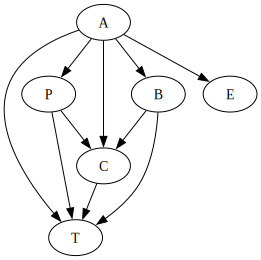

In [26]:
trophic_of_influence_graph(f.influence_graph())